# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


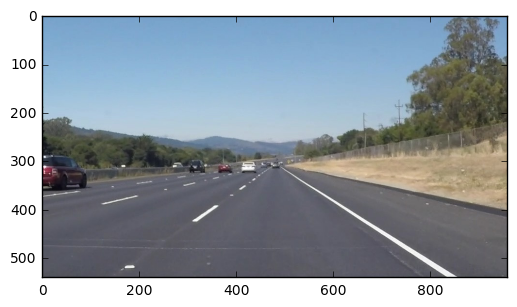

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)



def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, mask_height, color=[255, 0, 0], thickness=5):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    l_lines = []
    r_lines = []
    
    l_slopes = []
    r_slopes = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
#             cv2.line(img, (x1, y1), (x2, y2), color, thickness) # original draw line code
            slope = (y2 - y1)/(x2 - x1)
    
            # separate line segments into right or left parts
            if slope < 0 and slope < -0.5 and slope != 0 and not np.isnan(slope):
                # do not save line segment with too steep slope
                    l_lines.append([x1,y1,x2,y2])
                    l_slopes.append(slope)
            else:
                if slope > 0 and slope > 0.5 and slope != 0 and not np.isnan(slope):
                    r_lines.append([x1,y1,x2,y2])
                    r_slopes.append(slope)
    
    # extrapolate line segments for the left lines
    if l_lines != []:
        try:
            l_lines = np.vstack(l_lines)

            l_av_slope = np.median(l_slopes)

            x2 = np.max(l_lines[:,2])
            y2 = np.min(l_lines[:,3])

            x1 = 0

            y1 = y2 - int(l_av_slope * x2)

            cv2.line(img, (x1, y1), (x2, y2), color, thickness=10)
        except Exception:
            pass
        
    # extrapolate line segments for the right lines
    if r_lines != []:
        try:
            r_lines = np.vstack(r_lines)

            r_av_slope = np.median(r_slopes)

            x1 = np.min(r_lines[:,0])
            y1 = np.min(r_lines[:,1])

            x2 = img.shape[1]

#             x2 = int((y2 - y1)/r_av_slope) + x1
            y2 = int((x2- x1) * r_av_slope) + y1
#             print((x1, y1), (x2, y2))
            cv2.line(img, (x1, y1), (x2, y2), color, thickness=10)
        except Exception:
            pass

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, mask_height):
    """
    `img` should be the output of a Canny transform.
    
    rho: distance resolution in pixels of the Hough grid
    theta: angular resolution in radians of the Hough grid
    threshold: minimum number of votes (intersections in Hough grid cell)
    min_line_length: minimum number of pixels making up a line
    max_line_gap: maximum gap in pixels between connectable line segments
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines, mask_height)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

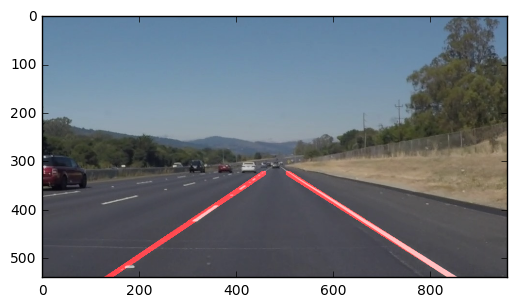

In [4]:
import os
image_dir = "test_images/"
image_list = os.listdir(image_dir)

# for image_name in image_list:
#     # read image
image_name = image_list[5]
image = (mpimg.imread("test_images/"+image_name)) # we choose one of the images to work with
imshape = np.shape(image)
# convert to grayscale
gray = grayscale(image)

# smooth the image for better performance
gray_smoothed = gaussian_blur(gray, kernel_size=5)

# apply canny edge detection
edges = canny(gray_smoothed, low_threshold=60, high_threshold=180)

mask_height = 325

# apply a region of interest
vertices = np.array([[(150,imshape[0]),(430, mask_height), (530, mask_height), (imshape[1],imshape[0])]], dtype=np.int32)
roi_image = region_of_interest(edges, vertices)

# apply hough transform
lined_image = hough_lines(roi_image, rho=2, theta=np.pi/180, 
                          threshold=45, min_line_len=50, max_line_gap=150, mask_height=mask_height)

final_image = weighted_img(lined_image, image)
# save image
# new_image_name = image_dir + 'solutions_1/new_' + image_name
#     cv2.imwrite(new_image_name, final_image)
# plt.imsave(new_image_name, final_image)

# plt.imshow(edges, cmap='gray')
plt.imshow(final_image)

run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

In [5]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [6]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    
    imshape = np.shape(image)
    # convert to grayscale
    gray = grayscale(image)

    # smooth the image for better performance
    gray_smoothed = gaussian_blur(gray, kernel_size=3)

    # apply canny edge detection
    edges = canny(gray_smoothed, low_threshold=60, high_threshold=180)

    mask_height = 325

    # apply a region of interest
    vertices = np.array([[(100,imshape[0]),(430, mask_height), (530, mask_height), (imshape[1],imshape[0])]], dtype=np.int32)
    roi_image = region_of_interest(edges, vertices)

    # apply hough transform
    lined_image = hough_lines(roi_image, rho=2, theta=np.pi/180, 
                              threshold=50, min_line_len=50, max_line_gap=150, mask_height=mask_height)

    result = weighted_img(lined_image, image)

    return result

Let's try the one with the solid white lane on the right first ...

In [7]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:07<00:00, 28.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 1min 19s, sys: 3.06 s, total: 1min 22s
Wall time: 8.26 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [8]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:28<00:00, 23.75it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 4min 50s, sys: 10.4 s, total: 5min
Wall time: 29.1 s


## Reflections: 
The project takes more time than I expected, though the objectives seem simple from first look. 
More time was spent tuning the parameters of the Canny edges and the Hough lines. To reduce the number of parameters to be tuned, I checked out a tutorial [http://www.pyimagesearch.com/2015/04/06/zero-parameter-automatic-canny-edge-detection-with-python-and-opencv/] where I could instead use only one parameter for tunning the canny edges. 

In other to extrapolate the lines, I used the extents of the mask applied on the image, calculated an average slope of the lines from Hough, and got new points for the edges of the image. However this method does not seem to work for the challenge question.

Though I am not satisfied with the result so far, I had to submit because I had already spent more than the 10 hours I estimated to spend weekly on the project. I hope I can improve the result as time goes on and as I understand more about the projects in the program.

#### Reflection after first review:
I made the anotations less dependent on the ROI, used median slope and filtered out outliers. I think this approach gave a better result and also worked to a large extent on the challenge video.
More work can be done to reduce the flickering.
In my opinion, this is not a definitve approach so I hope to learn a better and more advanced approach going forward in the Nanodegree program.

## Optional Challenge

In [9]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:20<00:00, 15.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 3min 29s, sys: 7.41 s, total: 3min 36s
Wall time: 21.4 s


## Feedback from reviewer:


I see you put a lot of effort in trying to solve this challenge. Excellent work! You are on the right track. The current SDC course has not yet covered curve line detection and I believe it will be taught in the future content. In case you want to know more about the topics I have attached a few research papers that provide a more detailed explanation and concepts regarding to detecting curved lines.
    
http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.106.6644&rep=rep1&type=pdf

http://www.vision.caltech.edu/malaa/publications/aly08realtime.pdf

https://arxiv.org/pdf/1501.03124.pdf
    
Also, there are different approach to come up with a better pipeline, one way is to tune your parameter in an optimal way. If you are interested in other approaches, check out these two link below, this will give you an idea on how these other experts solved this same problem by building their line detection algorithms.

http://www.transistor.io/revisiting-lane-detection-using-opencv.html

http://stackoverflow.com/questions/36598897/python-and-opencv-improving-my-lane-detection-algorithm
